# BTC/USD Price Forecast Model
Analysis to determine the ideal model to predict future BTC prices.

In [2]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Helper Functions

In [3]:
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic: %f" % result[0])
    print("p-value: %f" % result[1])

## Import Data

In [4]:
btc_usd_df = pd.read_csv("BTC-USD_1y200101d.csv", parse_dates=[0], index_col=0, squeeze=True, date_parser=lambda s: datetime.strptime(s, "%Y-%m-%d")).dropna()
btc_usd_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,1.856566e+10
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,2.080208e+10
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,2.811148e+10
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,1.844427e+10
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,1.972507e+10


In [5]:
btc_usd_close_df = btc_usd_df.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"]).dropna()
btc_usd_close_df.head()

,Close
Date,
2020-01-01,7200.174316
2020-01-02,6985.470215
2020-01-03,7344.884277
2020-01-04,7410.656738
2020-01-05,7411.317383


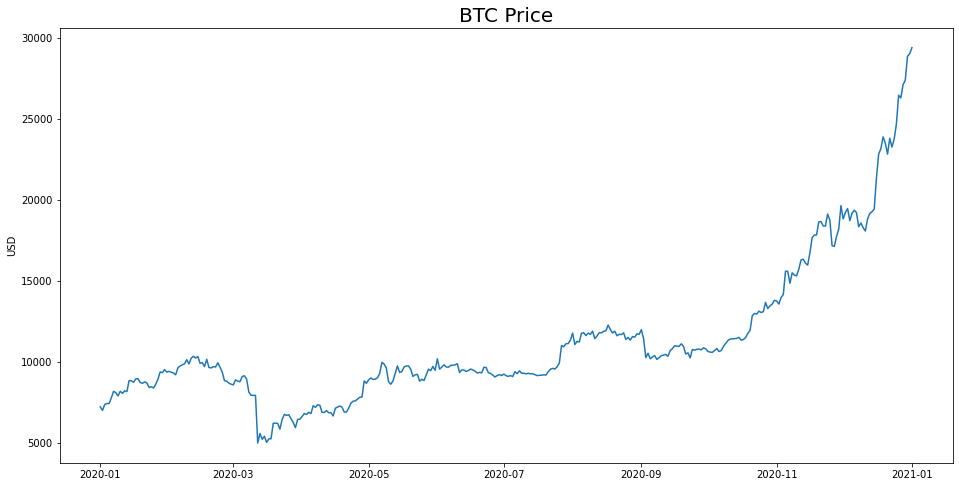

In [6]:
plt.figure(figsize=(16, 8))
plt.title("BTC Price", fontsize=20)
plt.ylabel("USD")
plt.plot(btc_usd_close_df.Close)

## Normalization

In [7]:
mean_close, std_close = btc_usd_close_df.Close.mean(), btc_usd_close_df.Close.std()

# z-score normalization
btc_usd_close_df['Close_n'] = (btc_usd_close_df.Close - mean_close) / std_close

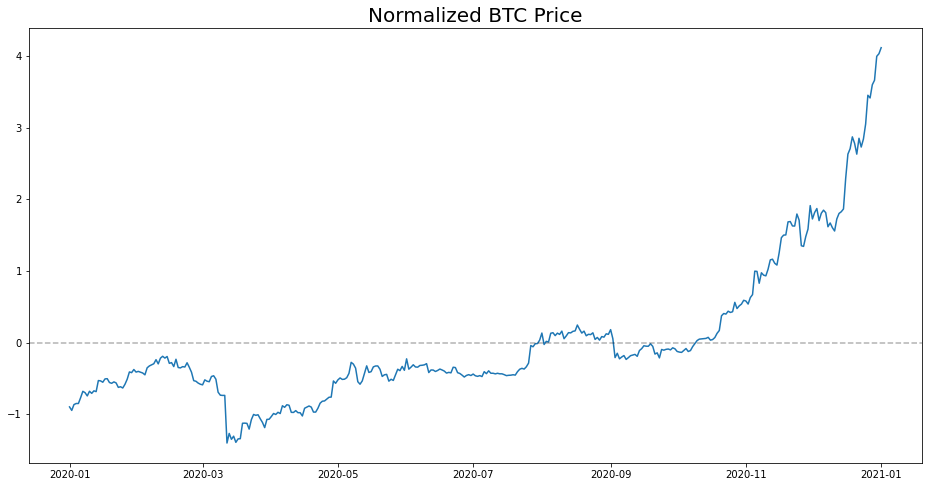

In [8]:
plt.figure(figsize=(16,8))
plt.title("Normalized BTC Price", fontsize=20)
plt.plot(btc_usd_close_df.Close_n)
plt.axhline(y=0, linestyle='--', color='k', alpha=0.3)

## Stationarize

### First Difference

In [9]:
btc_usd_close_df['Diff_1'] = btc_usd_close_df.Close_n.diff().dropna()

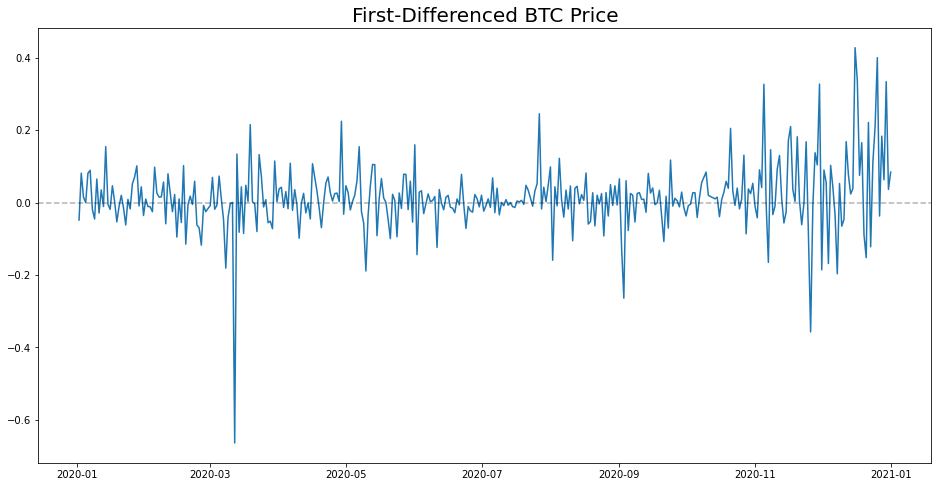

In [10]:
plt.figure(figsize=(16,8))
plt.title("First-Differenced BTC Price", fontsize=20)
plt.plot(btc_usd_close_df.Diff_1)
plt.axhline(y=0, linestyle='--', color='k', alpha=0.3)

### ADF-Test for First-Differenced BTC Price Series

In [11]:
adf_test(btc_usd_close_df.Diff_1.dropna())

ADF Statistic: -2.654813
p-value: 0.082189


### ACF for First-Differenced BTC Price

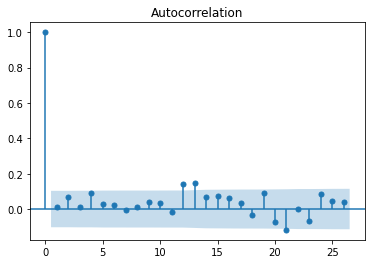

In [12]:
plot_acf(btc_usd_close_df.Diff_1.dropna())
plt.show()

## MA(12), MA(13)

### PACF for First-Differenced BTC Price

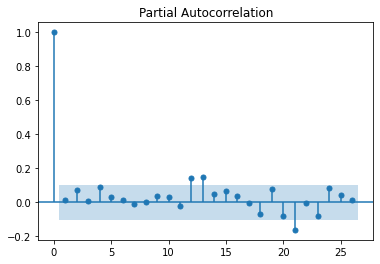

In [348]:
plot_pacf(btc_usd_close_df.Diff_1.dropna())
plt.show()

## AR(12), AR(13), AR(21)

## ARMA(12, 12), ARMA(12, 13),
## ARMA(13, 12), ARMA(13, 13),
## ARMA(21, 12), ARMA(21, 13)

### Second Difference

In [13]:
btc_usd_close_df["Diff_2"] = btc_usd_close_df.Diff_1.diff().dropna()

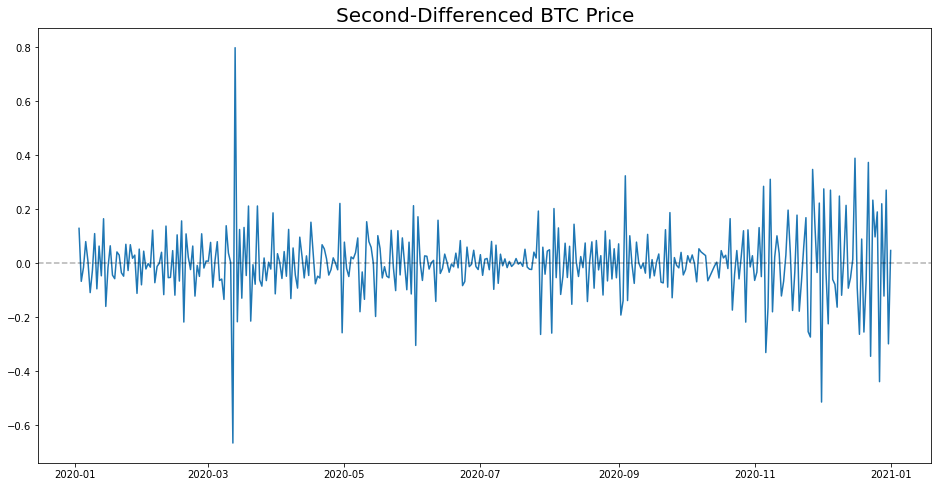

In [14]:
plt.figure(figsize=(16,8))
plt.title("Second-Differenced BTC Price", fontsize=20)
plt.plot(btc_usd_close_df.Diff_2)
plt.axhline(y=0, linestyle='--', color='k', alpha=0.3)

### ADF-Test for Second-Differenced BTC Price

In [15]:
adf_test(btc_usd_close_df.Diff_2.dropna())

ADF Statistic: -7.798695
p-value: 0.000000


### ACF for Second-Differenced BTC Price

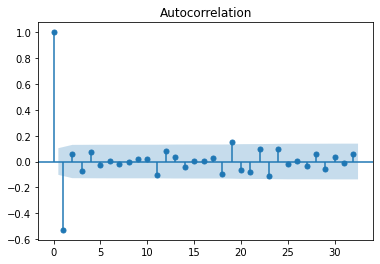

In [19]:
plot_acf(btc_usd_close_df.Diff_2.dropna(), lags=32)
plt.show()

## MA(1), MA(19)

### PACF for Second-Differenced BTC Price

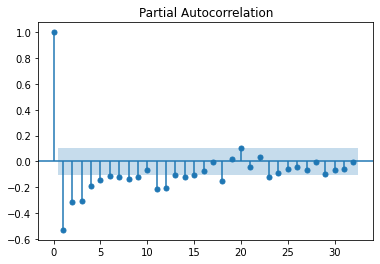

In [18]:
plot_pacf(btc_usd_close_df.Diff_2.dropna(), lags=32)
plt.show()

## AR(1), AR(2), AR(3), AR(4), AR(5), AR(6), AR(7), AR(8), AR(9), AR(11), AR(12), AR(13), AR(14), AR(15), AR(18), AR(23)

## ARMA(1, 1), ARMA(1, 19),
## ARMA(2, 1), ARMA(2, 19),
## ARMA(3, 1), ARMA(3, 19),
## ARMA(4, 1), ARMA(4, 19),
## ARMA(5, 1), ARMA(5, 19),
## ARMA(6, 1), ARMA(6, 19),
## ARMA(7, 1), ARMA(7, 19),
## ARMA(8, 1), ARMA(8, 19),
## ARMA(9, 1), ARMA(9, 19),
## ARMA(11, 1), ARMA(11, 19),
## ARMA(12, 1), ARMA(12, 19),
## ARMA(13, 1), ARMA(13, 19),
## ARMA(14, 1), ARMA(14, 19),
## ARMA(15, 1), ARMA(15, 19),
## ARMA(18, 1), ARMA(18, 19),
## ARMA(23, 1), ARMA(23, 19)

In [20]:
p_params = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 18, 23]
q_params = [1, 19]

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

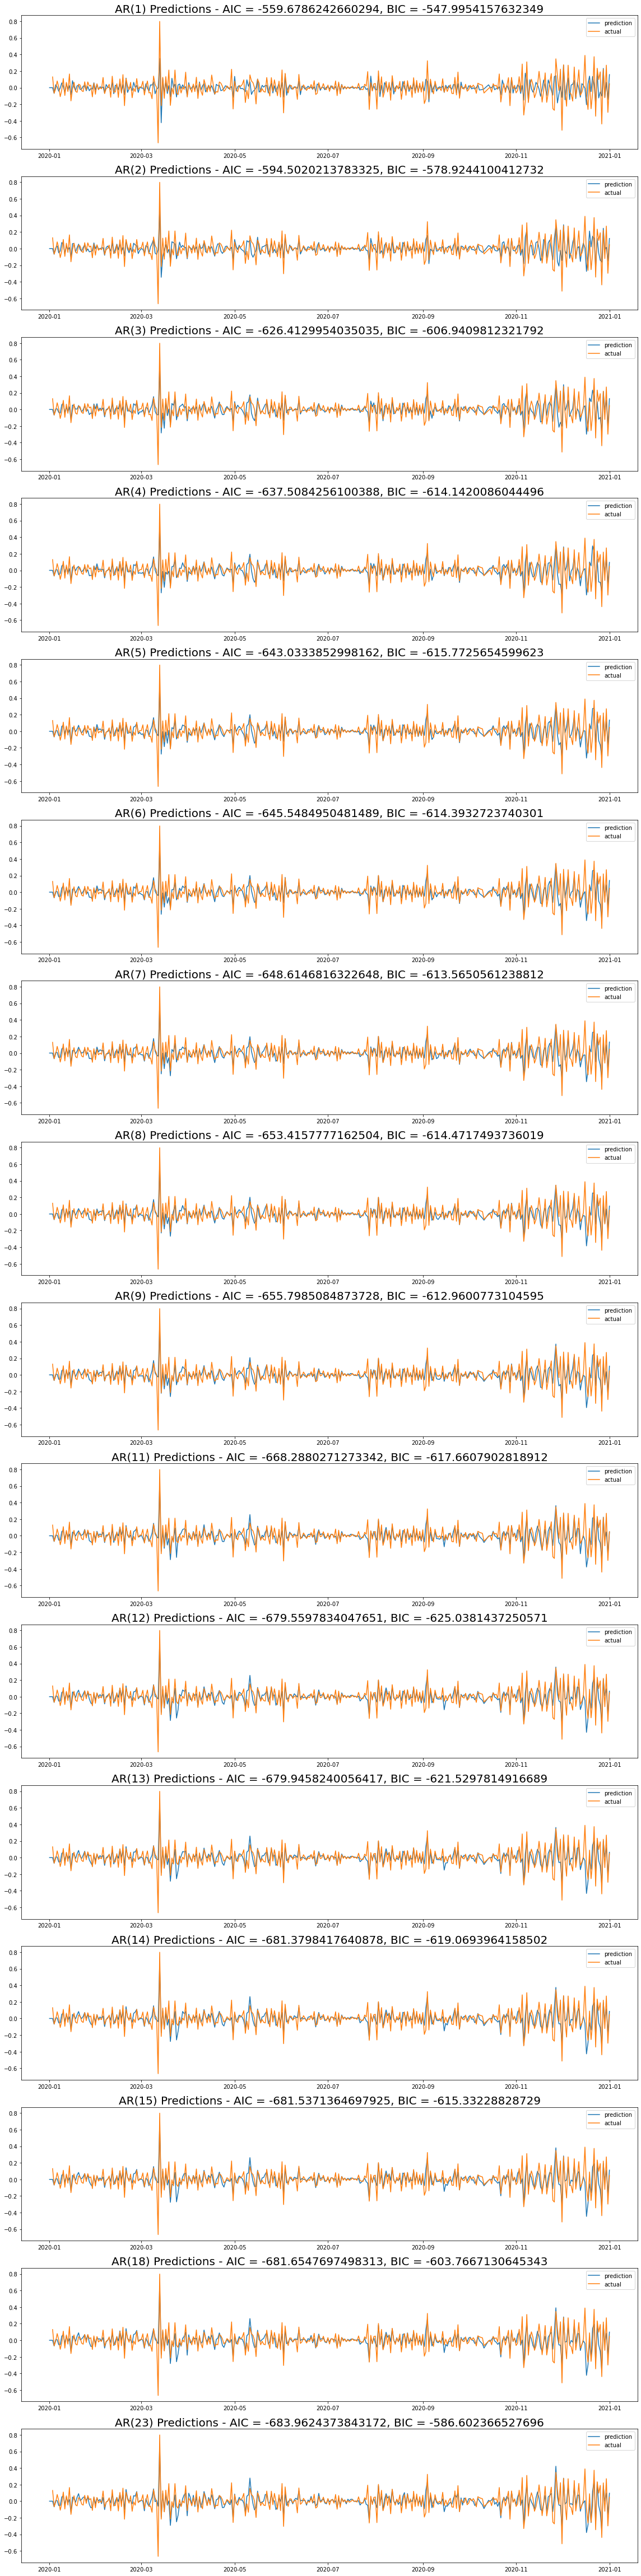

In [27]:
plt.figure(figsize=(16, 64))
for i, p in enumerate(p_params):
    model = ARIMA(btc_usd_close_df.Diff_2, order=(p, 0, 0))
    model_fit = model.fit()
    plt.subplot(len(p_params), 1, i + 1)
    plt.title("AR(%s) Predictions - AIC = %s, BIC = %s" % (p, model_fit.aic, model_fit.bic), fontsize=20)
    plt.plot(model_fit.fittedvalues, label="prediction")
    plt.plot(btc_usd_close_df.Diff_2, label="actual")
    plt.legend()
plt.tight_layout()

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

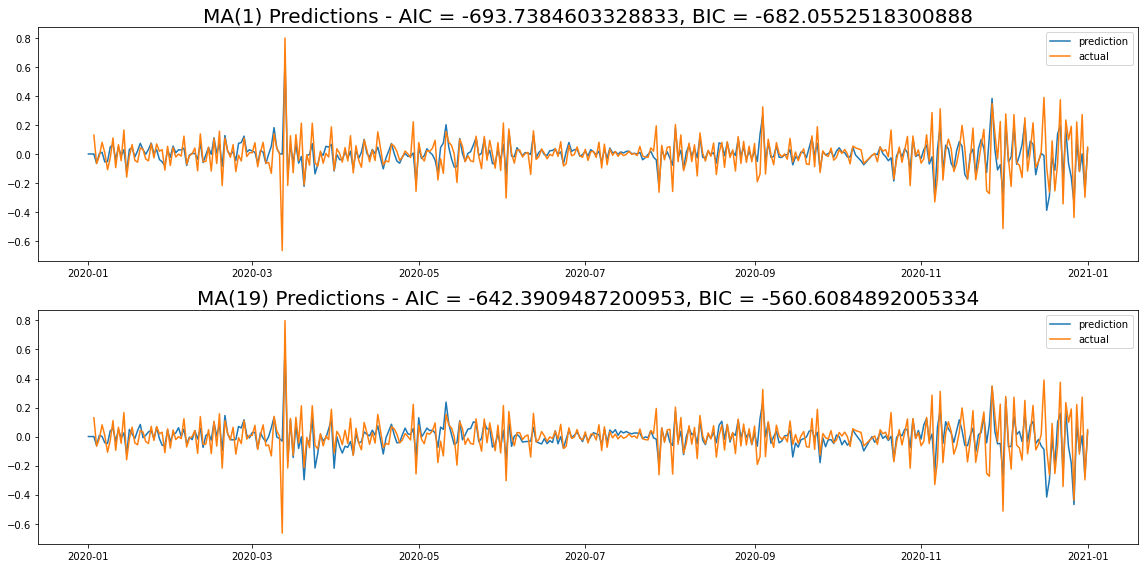

In [26]:
plt.figure(figsize=(16, 8))
for i, q in enumerate(q_params):
    model = ARIMA(btc_usd_close_df.Diff_2, order=(0, 0, q))
    model_fit = model.fit()
    plt.subplot(len(q_params), 1, i + 1)
    plt.title("MA(%s) Predictions - AIC = %s, BIC = %s" % (q, model_fit.aic, model_fit.bic), fontsize=20)
    plt.plot(model_fit.fittedvalues, label="prediction")
    plt.plot(btc_usd_close_df.Diff_2, label="actual")
    plt.legend()
plt.tight_layout()